# COMPARATIVA LEO MESSI VS LAMINE YAMAL

### ¿SERÁ TAN BUENO ALGÚN DÍA EL JOVEN ESPAÑOL COMO EL ASTRO ARGENTINO?

 EN ESTE PROYECTO PROFUNDIZAREMOS EN LOS DATOS Y ASENTAREMOS LAS BASES PARA UNA FUTURA PREDICCIÓN QUE NOS CONFIRME, EN LA MEDIDA DE LO POSIBLE, SI LAMINE CONSEGUIRÉ UN BALÓN DE ORO ANTES DE LA EDAD DE 22 AÑOS, EDAD A LA QUE MESSI LO CONSIGUIÓ POR PRIMERA VEZ. POR AHORA REALIZAREMOS COMPARATIVAS Y SACAREMOS CONCLUSIONES BASADOS EN LOS 3 PRIMEROS AÑOS DE SUS CARRERAS.

## 🔎 ¿Cómo ha sido el rendimiento de Leo Messi a lo largo de toda su carrera?

### 🧩 Premisa: Messi tiene una de las carreras más espectaculares de la historia del fútbol.

    Total de partidos, goles, asistencias y minutos.

    Goles/asistencias por temporada, año, mes, edad, condición (local/visitante), rival y competición.

    Evolución de estadísticas a lo largo del tiempo.

    Visualizaciones acumuladas y comparativas.

## 🔎 ¿Está Lamine Yamal siguiendo un camino prometedor en sus primeros años?

### 🧩 Premisa: Lamine debutó a una edad muy temprana con gran protagonismo.

    Análisis de sus estadísticas desde el debut: goles, asistencias, minutos y titularidades.

    Comparación con los primeros años de Messi: ¿Quién empezó más fuerte?

    Evolución temporada a temporada.

    Goles/asistencias por edad, condición, rival, competición y tipo de partido.

    Participación como titular vs suplente.

## 🔎 ¿Realmente son similares los comienzos de ambas estrellas?

### 🧩 Premisa: La edad puede influir en el rendimiento, pero también lo hace la experiencia.

    Goles y asistencias por año de edad (edad real, no temporada).

    Comparación entre Messi y Lamine a la misma edad.

    ¿Quién fue más determinante con menos experiencia?

    Visualizaciones paralelas para facilitar la comparación.

## 🔎 ¿Qué equipos han sufrido más los goles de Messi y Lamine?

### 🧩 Premisa: Algunos rivales han sido “víctimas” recurrentes de ambos jugadores.

    Ranking de rivales más goleados por jugador.

    Goles como local y visitante por rival.

    Comparación entre clubes y selecciones.

    Goles por equipo filtrados por temporada.



## 🔎 ¿En qué contextos rinden mejor cada uno?

### 🧩 Premisa: No todos los jugadores rinden igual en todas las condiciones.

    Desempeño local vs visitante.

    Diferencia de rendimiento en club vs selección.

    Goles/asistencias por tipo de competición (Champions, liga, Copa, selecciones).

    % de contribución en goles vs asistencias (¿finalizador o generador?).

## 🔎 Basado en los números exclusivamente, ¿conseguirá Lamine un Balón de Oro antes de los 22 años?

### 🧩 Premisa: La comparación puede servir como espejo y guía para proyectar el futuro de Lamine.

    Comparativa directa entre ambos jugadores en sus primeros años.

    Evolución de la participación ofensiva.

    Diferencia de estilos a partir de las estadísticas.

    Predicción y visualización de posibles trayectorias (modelo de regresión).

    Análisis de rendimiento relativo (Goal Contribution por 90, % de participación, etc.).

# Preparación del código

In [46]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

In [47]:
# Confirmar la raíz del proyecto (en caso de ser necesario hacerlo)
# Esto es necesario para que el código funcione correctamente en Jupyter Notebook

from pathlib import Path
import os

def find_project_root(marker_file="F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Evolve_Proyecto_Abril"):
    """Busca la raíz del proyecto basado en un archivo marcador."""
    current = Path.cwd().resolve()

    while current != current.parent:
        if (current / marker_file).exists():
            return current
        current = current.parent

    raise FileNotFoundError(f"No se encontró el archivo marcador {marker_file} en ninguna carpeta padre.")

# Usamos esto al inicio de cualquier archivo para fijar la raíz del proyecto
project_root = find_project_root()
os.chdir(project_root)  # OPCIONAL: cambia el cwd real si estás en Jupyter
print(f"📁 Carpeta raíz fijada a: {project_root}")



📁 Carpeta raíz fijada a: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril


In [48]:
# Raíz actualizada
# Cambiar el directorio de trabajo al directorio raíz del proyecto

import os
from pathlib import Path

# Cambiar al directorio raíz del proyecto (subí hasta donde esté "main.py" o ".git", etc.)
project_root = Path(os.getcwd()).resolve()

while not (project_root / "main.py").exists() and project_root != project_root.parent:
    project_root = project_root.parent

os.chdir(project_root)
print(f"📁 Working directory cambiado a: {project_root}")


📁 Working directory cambiado a: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril


In [49]:
# Scraping de Lamine Yamal

import pandas as pd
from pathlib import Path
import time

# Rutas y carpeta
project_root = Path().resolve()
lamine_raw_path = project_root / "data/raw/lamine_raw_data.csv"
lamine_raw_path.parent.mkdir(parents=True, exist_ok=True)

# URLs de FBRef
LAMINE_URLS = [
    "https://fbref.com/en/players/82ec26c1/matchlogs/2022-2023/Lamine-Yamal-Match-Logs",
    "https://fbref.com/en/players/82ec26c1/matchlogs/2023-2024/Lamine-Yamal-Match-Logs",
    "https://fbref.com/en/players/82ec26c1/matchlogs/2024-2025/Lamine-Yamal-Match-Logs"
]

def scrape_lamine_data():
    all_data = []

    for url in LAMINE_URLS:
        print(f"🌍 Scrapeando Lamine: {url}")
        try:
            df = pd.read_html(url, attrs={"id": "matchlogs_all"})[0]

            if df.columns.nlevels > 1:
                df.columns = df.columns.get_level_values(-1)

            df = df[df["Date"].notna()]
            season = url.split("/")[-2]
            df["Season"] = season
            all_data.append(df)

        except Exception as e:
            print(f"❌ Error en {url}: {e}")

        time.sleep(1)

    if not all_data:
        print("⚠️ No se encontraron datos de Lamine.")
        return

    df_yamal = pd.concat(all_data, ignore_index=True)
    df_yamal.to_csv(lamine_raw_path, index=False)
    print(f"✅ CSV guardado en {lamine_raw_path} con {len(df_yamal)} filas.")

# Ejecutar
scrape_lamine_data()


🌍 Scrapeando Lamine: https://fbref.com/en/players/82ec26c1/matchlogs/2022-2023/Lamine-Yamal-Match-Logs
🌍 Scrapeando Lamine: https://fbref.com/en/players/82ec26c1/matchlogs/2023-2024/Lamine-Yamal-Match-Logs
🌍 Scrapeando Lamine: https://fbref.com/en/players/82ec26c1/matchlogs/2024-2025/Lamine-Yamal-Match-Logs
✅ CSV guardado en F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril\data\raw\lamine_raw_data.csv con 118 filas.


In [50]:
df_yamal = pd.read_csv("data/raw/lamine_raw_data.csv")
print(df_yamal.head(2))  # Verificar que se haya cargado correctamente

         Date  Day     Comp         Round Venue Result      Squad  \
0  2023-04-23  Sun  La Liga  Matchweek 30  Home  W 1–0  Barcelona   
1  2023-04-26  Wed  La Liga  Matchweek 31  Away  L 1–2  Barcelona   

          Opponent Start                                  Pos  ...  \
0  Atlético Madrid     N  On matchday squad, but did not play  ...   
1   Rayo Vallecano     N  On matchday squad, but did not play  ...   

                                   Cmp                                  Att  \
0  On matchday squad, but did not play  On matchday squad, but did not play   
1  On matchday squad, but did not play  On matchday squad, but did not play   

                                  Cmp%                                 PrgP  \
0  On matchday squad, but did not play  On matchday squad, but did not play   
1  On matchday squad, but did not play  On matchday squad, but did not play   

                               Carries                                 PrgC  \
0  On matchday squad, but 

In [51]:
# Procesar datos de Lamine Yamal

import pandas as pd
from pathlib import Path
from datetime import datetime

def process_lamine_data(input_rel="data/raw/lamine_raw_data.csv", output_rel="data/processed/lamine_cleaned_data.csv", return_df=True, decimal=","):
    project_root = Path().resolve()
    input_path = project_root / input_rel
    output_path = project_root / output_rel
    output_path.parent.mkdir(parents=True, exist_ok=True)

    df_yamal = pd.read_csv(input_path)
    birthdate = pd.to_datetime("2007-07-13")

    df_yamal["Date"] = pd.to_datetime(df_yamal["Date"], errors="coerce")

    def asignar_temporada(fecha):
        if pd.isna(fecha):
            return None
        year = fecha.year
        return f"{year}-{year + 1}" if fecha.month >= 8 else f"{year - 1}-{year}"

    df_yamal["Season"] = df_yamal["Date"].apply(asignar_temporada)
    df_yamal["Age"] = df_yamal["Date"].apply(lambda d: round((d - birthdate).days / 365.25, 2) if pd.notna(d) else None)
    df_yamal["Lineup"] = df_yamal["Start"].apply(lambda s: "Starter" if s == "Y" else "Substitute")

    df_yamal["Squad"] = df_yamal["Squad"].str.replace(r"^[a-z]{2,3}\s", "", regex=True)
    df_yamal["Opponent"] = df_yamal["Opponent"].str.replace(r"^[a-z]{2,3}\s", "", regex=True)

    TEAM_NAME_FIXES = {
        "Barcelona": "FC Barcelona",
        "Betis": "Real Betis",
        "Athletic Club": "Athletic de Bilbao",
        "Celta Vigo": "Celta de Vigo",
        "Paris S-G": "Paris Saint-Germain",
        "Shakhtar": "Shakhtar Donetsk",
        "Almeria": "UD Almería",
        "Porto": "FC Porto",
        "Mallorca": "Real Mallorca",
        "Antwerp": "Antwerp",
        "Osasuna": "Osasuna",
        "Napoli": "Napoli",
        "Las Palmas": "Las Palmas",
        "Granada": "Granada",
        "Valencia": "Valencia",
        "Real Sociedad": "Real Sociedad",
        "Atlético Madrid": "Atlético Madrid",
        "Real Madrid": "Real Madrid",
        "Sevilla": "Sevilla",
        "Girona": "Girona",
        "Alavés": "Alavés",
        "Rayo Vallecano": "Rayo Vallecano",
        "Getafe": "Getafe",
        "Cádiz": "Cádiz",
        "Bayern Munich": "Bayern München",
        "Young Boys": "Young Boys",
        "Dortmund": "Borussia Dortmund",
        "Red Star": "Red Star Belgrade",
        "Valladolid": "Real Valladolid",
        "Andorra": "Andorra",
        "Cyprus": "Cyprus",
        "Georgia": "Georgia",
        "Denmark": "Denmark",
        "Serbia": "Serbia",
        "Monaco": "AS Monaco",
        "Atalanta": "Atalanta",
        "England": "England",
        "Northern Ireland": "Northern Ireland"
    }

    df_yamal["Squad"] = df_yamal["Squad"].replace(TEAM_NAME_FIXES)
    df_yamal["Opponent"] = df_yamal["Opponent"].replace(TEAM_NAME_FIXES)

    def limpiar_resultado(valor):
        if pd.isna(valor):
            return None
        valor = str(valor).strip()
        if valor.startswith(("W", "D", "L")):
            partes = valor.split(" ")
            return partes[1] if len(partes) > 1 else None
        if valor.isdigit():
            return f"{valor}-{valor}"
        return valor.replace("–", "-")

    df_yamal["Result"] = df_yamal["Result"].apply(limpiar_resultado)

    COMP_FIXES = {
        "La Liga": "La Liga",
        "Champions Lg": "UEFA Champions League",
        "Copa del Rey": "Copa del Rey",
        "Supercopa de España": "Spanish Super Cup",
        "Friendlies (M)": "International friendly",
        "UEFA Nations League": "UEFA Nations League",
        "UEFA Euro Qualifying": "UEFA Euro Qualification",
        "UEFA Euro": "UEFA Euro"
    }
    df_yamal["Comp"] = df_yamal["Comp"].replace(COMP_FIXES)

    df_cleaned = pd.DataFrame()
    df_cleaned["Date"] = df_yamal["Date"]
    df_cleaned["Season"] = df_yamal["Season"]
    df_cleaned["Age"] = df_yamal["Age"].apply(lambda x: f"{x:.2f}".replace(".", ",") if pd.notna(x) else "")
    df_cleaned["Player"] = "Lamine Yamal"

    df_cleaned["Home Team"] = df_yamal.apply(lambda row: row["Squad"] if row["Venue"] == "Home" else row["Opponent"], axis=1)
    df_cleaned["Away Team"] = df_yamal.apply(lambda row: row["Opponent"] if row["Venue"] == "Home" else row["Squad"], axis=1)
    df_cleaned["Competition"] = df_yamal["Comp"]
    df_cleaned["Result"] = df_yamal["Result"]
    df_cleaned["Lineup"] = df_yamal["Lineup"]

    for col in ["Min", "Gls", "Ast", "CrdY"]:
        df_cleaned[col] = pd.to_numeric(df_yamal.get(col, 0), errors="coerce").fillna(0).astype(int)

    df_cleaned.rename(columns={
        "Min": "Minutes",
        "Gls": "Goals",
        "Ast": "Assists",
        "CrdY": "Cards"
    }, inplace=True)

    df_cleaned["Player_Team"] = df_cleaned.apply(lambda row: "Spain" if "international" in row["Competition"].lower() else "FC Barcelona", axis=1)
    df_cleaned["Home/Away"] = df_cleaned.apply(lambda row: "Home" if row["Home Team"] == row["Player_Team"] else "Away", axis=1)
    df_cleaned["Rival_Team_Name"] = df_cleaned.apply(lambda row: row["Away Team"] if row["Player_Team"] == row["Home Team"] else row["Home Team"], axis=1)

    df_cleaned.to_csv(output_path, index=False, sep=",", encoding="utf-8", decimal=decimal)
    print(f"✅ Datos procesados guardados en: {output_path}")
    if return_df:
        return df_cleaned





In [52]:
df_cleaned = pd.read_csv("data/processed/lamine_cleaned_data.csv")
print(df_cleaned.head(2))  # Verificar que se haya cargado correctamente

         Date     Season    Age        Player       Home Team  \
0  2023-04-23  2022-2023  15,78  Lamine Yamal    FC Barcelona   
1  2023-04-26  2022-2023  15,79  Lamine Yamal  Rayo Vallecano   

         Away Team Competition Result      Lineup  Minutes  Goals  Assists  \
0  Atlético Madrid     La Liga    1–0  Substitute        0      0        0   
1     FC Barcelona     La Liga    1–2  Substitute        0      0        0   

   Cards   Player_Team Home/Away  Rival_Team_Name  
0      0  FC Barcelona      Home  Atlético Madrid  
1      0  FC Barcelona      Away   Rayo Vallecano  


In [53]:
df_cleaned_yamal = process_lamine_data(return_df=True)
print(df_cleaned_yamal.head())
print(f"✅ El DataFrame procesado tiene {len(df_cleaned_yamal)} filas.")

✅ Datos procesados guardados en: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril\data\processed\lamine_cleaned_data.csv
        Date     Season    Age        Player       Home Team        Away Team  \
0 2023-04-23  2022-2023  15,78  Lamine Yamal    FC Barcelona  Atlético Madrid   
1 2023-04-26  2022-2023  15,79  Lamine Yamal  Rayo Vallecano     FC Barcelona   
2 2023-04-29  2022-2023  15,79  Lamine Yamal    FC Barcelona       Real Betis   
3 2023-05-02  2022-2023  15,80  Lamine Yamal    FC Barcelona          Osasuna   
4 2023-08-13  2023-2024  16,08  Lamine Yamal          Getafe     FC Barcelona   

  Competition Result      Lineup  Minutes  Goals  Assists  Cards  \
0     La Liga    1–0  Substitute        0      0        0      0   
1     La Liga    1–2  Substitute        0      0        0      0   
2     La Liga    4–0  Substitute        8      0        0      0   
3     La Liga    1–0  Substitute        0      0        0      0   
4     La Liga    0–0  

In [54]:
# Scraping de Messi

import requests
from bs4 import BeautifulSoup
import pandas as pd
from pathlib import Path

# Rutas y carpeta
project_root = Path().resolve()
messi_raw_path = project_root / "data/raw/messi_raw_data.csv"
messi_raw_path.parent.mkdir(parents=True, exist_ok=True)

# URLs de todas las temporadas de Messi
URL_LIST_MESSI = [
    "https://www.messistats.com/en/games/0/0/all/0/2/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/3/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/4/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/5/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/6/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/7/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/8/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/9/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/10/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/11/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/12/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/13/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/14/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/15/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/16/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/17/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/18/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/19/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/20/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/21/0/t/0/0/0/1",
    "https://www.messistats.com/en/games/0/0/all/0/24/0/t/0/0/0/1",
]

def scrape_messi_data():
    all_data = []

    for url in URL_LIST_MESSI:
        print(f"🌐 Scrapeando Messi: {url}")
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")

        headers = [
            "Index", "Date", "Competition", "Home Team", "Result", "Away Team",
            "Lineup", "Minutes", "Goals", "Assists", "Cards", "Jersey", "Extra"
        ]

        data = []
        for row in soup.find_all("tr"):
            cols = [col.text.strip() for col in row.find_all("td")]
            if cols:
                data.append(cols)

        if data:
            df = pd.DataFrame(data, columns=headers[:len(data[0])])
            all_data.append(df)

    if not all_data:
        print("⚠️ No se encontraron datos.")
        return

    df_total = pd.concat(all_data, ignore_index=True)

    if messi_raw_path.exists():
        df_existing = pd.read_csv(messi_raw_path, dtype=str, on_bad_lines='skip')
        df_combined = pd.concat([df_existing, df_total], ignore_index=True)
    else:
        df_combined = df_total

    df_combined.drop_duplicates(subset=["Date", "Home Team", "Away Team"], keep="last", inplace=True)
    df_combined.to_csv(messi_raw_path, index=False, encoding="utf-8")
    print(f"✅ CSV actualizado: {messi_raw_path} con {len(df_combined)} registros.")

# Ejecutar
scrape_messi_data()



🌐 Scrapeando Messi: https://www.messistats.com/en/games/0/0/all/0/2/0/t/0/0/0/1
🌐 Scrapeando Messi: https://www.messistats.com/en/games/0/0/all/0/3/0/t/0/0/0/1
🌐 Scrapeando Messi: https://www.messistats.com/en/games/0/0/all/0/4/0/t/0/0/0/1
🌐 Scrapeando Messi: https://www.messistats.com/en/games/0/0/all/0/5/0/t/0/0/0/1
🌐 Scrapeando Messi: https://www.messistats.com/en/games/0/0/all/0/6/0/t/0/0/0/1
🌐 Scrapeando Messi: https://www.messistats.com/en/games/0/0/all/0/7/0/t/0/0/0/1
🌐 Scrapeando Messi: https://www.messistats.com/en/games/0/0/all/0/8/0/t/0/0/0/1
🌐 Scrapeando Messi: https://www.messistats.com/en/games/0/0/all/0/9/0/t/0/0/0/1
🌐 Scrapeando Messi: https://www.messistats.com/en/games/0/0/all/0/10/0/t/0/0/0/1
🌐 Scrapeando Messi: https://www.messistats.com/en/games/0/0/all/0/11/0/t/0/0/0/1
🌐 Scrapeando Messi: https://www.messistats.com/en/games/0/0/all/0/12/0/t/0/0/0/1
🌐 Scrapeando Messi: https://www.messistats.com/en/games/0/0/all/0/13/0/t/0/0/0/1
🌐 Scrapeando Messi: https://www.mess

In [55]:
# Procesamiento datos de Messi

import pandas as pd
from pathlib import Path
from datetime import datetime

# -------------------- FUNCIONES AUXILIARES --------------------

def deducir_equipo_jugador(row, jugador="Messi"):
    temporada = row["Season"]
    comp = str(row["Competition"])
    home = row["Home Team"]
    away = row["Away Team"]

    if pd.isna(temporada) or pd.isna(comp):
        return "Unknown"

    if jugador == "Messi":
        if "argentina" in comp.lower() or home == "Argentina" or away == "Argentina":
            return "Argentina"
        elif temporada <= "2020-2021":
            return "FC Barcelona"
        elif temporada in ["2021-2022", "2022-2023"]:
            return "Paris Saint-Germain"
        elif temporada >= "2023-2024":
            return "Inter Miami CF"

    return "Unknown"

def obtener_rival(row):
    player_team = row["Player_Team"]
    home = row["Home Team"]
    away = row["Away Team"]

    if pd.isna(player_team) or pd.isna(home) or pd.isna(away):
        return None

    if player_team == home and away != player_team:
        return away
    elif player_team == away and home != player_team:
        return home
    else:
        return None

# -------------------- PROCESAMIENTO MESSI --------------------

def process_messi_data(input_rel="data/raw/messi_raw_data.csv", output_rel="data/processed/messi_cleaned_data.csv", return_df=False, decimal=","):
    project_root = Path().resolve()
    input_path = project_root / input_rel
    output_path = project_root / output_rel
    output_path.parent.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(input_path)

    df["Competition"] = df["Competition"].apply(lambda x: x.split("\n")[1].strip() if isinstance(x, str) and "\n" in x else x)
    df["Lineup"] = df["Lineup"].apply(lambda x: x.split("\n")[1].strip() if isinstance(x, str) and "\n" in x else x)

    df.drop(columns=["Index", "Jersey", "Extra"], inplace=True, errors="ignore")

    for col in ["Goals", "Assists", "Cards", "Minutes"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", errors="coerce", dayfirst=True)

    def asignar_temporada(fecha):
        if pd.isna(fecha):
            return None
        if datetime(2019, 8, 15) <= fecha <= datetime(2020, 8, 14):
            return "2019-2020"
        year = fecha.year
        return f"{year}-{year + 1}" if fecha.month >= 8 else f"{year - 1}-{year}"

    df["Season"] = df["Date"].apply(asignar_temporada)

    birthdate = pd.to_datetime("1987-06-24")
    df["Age"] = df["Date"].apply(lambda d: round((d - birthdate).days / 365.25, 2) if pd.notna(d) else None)
    df["Player"] = "Leo Messi"

    df["Player_Team"] = df.apply(lambda row: deducir_equipo_jugador(row, "Messi"), axis=1)
    df["Home/Away"] = df.apply(lambda row: "Home" if row["Home Team"] == row["Player_Team"] else "Away", axis=1)
    df["Rival_Team_Name"] = df.apply(obtener_rival, axis=1)

    df["Age"] = df["Age"].apply(lambda x: f"{x:.2f}".replace(".", ",") if pd.notna(x) else "")

    cols = ["Date", "Season", "Age", "Player", "Player_Team", "Home/Away", "Competition", "Home Team", "Result", "Away Team", "Rival_Team_Name", "Lineup", "Minutes", "Goals", "Assists", "Cards"]
    df = df[cols]

    df.to_csv(output_path, index=False, sep=",", decimal=decimal, encoding="utf-8")
    print(f"✅ Datos procesados guardados en: {output_path}")
    if return_df:
        return df

# Ejecutar procesamiento
process_messi_data()


✅ Datos procesados guardados en: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril\data\processed\messi_cleaned_data.csv


In [56]:
process_messi_data(input_rel="data/raw/messi_raw_data.csv", output_rel="data/processed/messi_cleaned_data.csv", return_df=False, decimal=",")

df_cleaned = process_messi_data(return_df=True)
print(f"✅ El DataFrame procesado tiene {len(df_cleaned)} filas.")
df_cleaned.head()


✅ Datos procesados guardados en: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril\data\processed\messi_cleaned_data.csv
✅ Datos procesados guardados en: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril\data\processed\messi_cleaned_data.csv
✅ El DataFrame procesado tiene 1092 filas.


,Date,Season,Age,Player,Player_Team,Home/Away,Competition,Home Team,Result,Away Team,Rival_Team_Name,Lineup,Minutes,Goals,Assists,Cards
0,2005-05-01,2004-2005,"17,85",Leo Messi,FC Barcelona,Home,La Liga,FC Barcelona,2-0,Albacete,Albacete,Substitute,3,1,0,0
1,2005-04-17,2004-2005,"17,82",Leo Messi,FC Barcelona,Home,La Liga,FC Barcelona,2-0,Getafe,Getafe,Substitute,5,0,0,0
2,2004-12-21,2004-2005,"17,49",Leo Messi,FC Barcelona,Home,La Liga,FC Barcelona,2-1,Levante,Levante,Substitute,33,0,0,0
3,2004-12-11,2004-2005,"17,47",Leo Messi,FC Barcelona,Away,La Liga,Albacete,1-2,FC Barcelona,Albacete,Substitute,1,0,0,0
4,2004-12-07,2004-2005,"17,46",Leo Messi,FC Barcelona,Away,UEFA Champions League,Shakhtar Donetsk,2-0,FC Barcelona,Shakhtar Donetsk,Starter,90,0,0,0


In [57]:
df = process_messi_data(return_df=True)

# Filtrar solo temporada 2019-2020
temporada_covid = df[df["Season"] == "2019-2020"]

print(f"📊 Partidos en la temporada 2019-2020: {len(temporada_covid)}")
temporada_covid.head()

✅ Datos procesados guardados en: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril\data\processed\messi_cleaned_data.csv
📊 Partidos en la temporada 2019-2020: 46


,Date,Season,Age,Player,Player_Team,Home/Away,Competition,Home Team,Result,Away Team,Rival_Team_Name,Lineup,Minutes,Goals,Assists,Cards
823,2020-08-14,2019-2020,"33,14",Leo Messi,FC Barcelona,Home,UEFA Champions League,FC Barcelona,2-8,Bayern München,Bayern München,Starter,90,0,0,0
824,2020-08-08,2019-2020,"33,13",Leo Messi,FC Barcelona,Home,UEFA Champions League,FC Barcelona,3-1,Napoli,Napoli,Starter,90,1,0,0
825,2020-07-19,2019-2020,"33,07",Leo Messi,FC Barcelona,Away,La Liga,Alavés,0-5,FC Barcelona,Alavés,Starter,90,2,1,0
826,2020-07-16,2019-2020,"33,06",Leo Messi,FC Barcelona,Home,La Liga,FC Barcelona,1-2,Osasuna,Osasuna,Starter,90,1,0,0
827,2020-07-11,2019-2020,"33,05",Leo Messi,FC Barcelona,Away,La Liga,Real Valladolid,0-1,FC Barcelona,Real Valladolid,Starter,90,0,1,0


In [58]:
print(f"📅 Primer partido: {temporada_covid['Date'].min().date()}")
print(f"📅 Último partido: {temporada_covid['Date'].max().date()}")

📅 Primer partido: 2019-09-17
📅 Último partido: 2020-08-14


In [59]:
# Cargar el CSV limpio en un DataFrame
df_cleaned = pd.read_csv('data/processed/messi_cleaned_data.csv')

# Ver las primeras filas para verificar que todo está bien
print(df_cleaned.head())


         Date     Season    Age     Player   Player_Team Home/Away  \
0  2005-05-01  2004-2005  17,85  Leo Messi  FC Barcelona      Home   
1  2005-04-17  2004-2005  17,82  Leo Messi  FC Barcelona      Home   
2  2004-12-21  2004-2005  17,49  Leo Messi  FC Barcelona      Home   
3  2004-12-11  2004-2005  17,47  Leo Messi  FC Barcelona      Away   
4  2004-12-07  2004-2005  17,46  Leo Messi  FC Barcelona      Away   

             Competition         Home Team Result     Away Team  \
0                La Liga      FC Barcelona    2-0      Albacete   
1                La Liga      FC Barcelona    2-0        Getafe   
2                La Liga      FC Barcelona    2-1       Levante   
3                La Liga          Albacete    1-2  FC Barcelona   
4  UEFA Champions League  Shakhtar Donetsk    2-0  FC Barcelona   

    Rival_Team_Name      Lineup  Minutes  Goals  Assists  Cards  
0          Albacete  Substitute        3      1        0      0  
1            Getafe  Substitute        5    

In [60]:
print(df_cleaned.columns)
# Mostrar el tipo de dato de la columna date
print(df_cleaned['Date'].dtype)

Index(['Date', 'Season', 'Age', 'Player', 'Player_Team', 'Home/Away',
       'Competition', 'Home Team', 'Result', 'Away Team', 'Rival_Team_Name',
       'Lineup', 'Minutes', 'Goals', 'Assists', 'Cards'],
      dtype='object')
object


In [61]:
import pandas as pd
from datetime import datetime

# Leer el archivo CSV correcto (data/processed/messi_cleaned_data.csv)
df_cleaned = pd.read_csv("data/processed/messi_cleaned_data.csv")

# Asegúrate de que la columna 'Date' esté en formato string (si no lo está)
df_cleaned['Date'] = df_cleaned['Date'].astype(str)

# Usar datetime para cambiar el formato de fecha de 'YYYY-MM-DD' a 'DD-MM-YYYY'
df_cleaned['Date'] = df_cleaned['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").strftime("%d-%m-%Y"))

# Ahora que la fecha está en el formato correcto, convertirla a datetime
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], format='%d-%m-%Y', errors='coerce')

# Mostrar las primeras filas para verificar que todo está correcto
print(df_cleaned[['Date']].head())

# Guardar el DataFrame actualizado en el archivo CSV correcto
df_cleaned.to_csv("data/processed/messi_cleaned_data.csv", index=False)

# Mostrar el tipo de dato de la columna date
print(df_cleaned['Date'].dtype)



        Date
0 2005-05-01
1 2005-04-17
2 2004-12-21
3 2004-12-11
4 2004-12-07
datetime64[ns]


# Estadística básica sobre ambos jugadores

In [62]:
import pandas as pd

# Cargar los datos procesados
df_messi = pd.read_csv("data/processed/messi_cleaned_data.csv")
df_lamine = pd.read_csv("data/processed/lamine_cleaned_data.csv")

# Cambiar columnas de coma a punto si hace falta
df_messi["Age"] = df_messi["Age"].str.replace(",", ".").astype(float)
df_lamine["Age"] = df_lamine["Age"].str.replace(",", ".").astype(float)

# ------------------------- #
# 1. Estadísticas descriptivas
print("🔹 Messi - Estadísticas Generales:")
print(df_messi[["Goals", "Assists", "Minutes", "Cards"]].describe())

print("\n🔹 Lamine - Estadísticas Generales:")
print(df_lamine[["Goals", "Assists", "Minutes", "Cards"]].describe())

# 2. Goles por equipo rival (top 5)
print("\n⚽ Top 5 rivales más goleados por Messi:")
print(df_messi.groupby("Rival_Team_Name")["Goals"].sum().sort_values(ascending=False).head(5))

print("\n⚽ Top 5 rivales más goleados por Lamine:")
print(df_lamine.groupby("Rival_Team_Name")["Goals"].sum().sort_values(ascending=False).head(5))

# 3. Goles por edad media
print("\n📈 Goles por temporada - Messi:")
print(df_messi.groupby("Season")["Goals"].sum())

print("\n📈 Goles por temporada - Lamine:")
print(df_lamine.groupby("Season")["Goals"].sum())


🔹 Messi - Estadísticas Generales:
             Goals      Assists      Minutes        Cards
count  1092.000000  1092.000000  1092.000000  1092.000000
mean      0.785714     0.349817    81.996337     0.090659
std       0.923200     0.626610    20.400571     0.287256
min       0.000000     0.000000     1.000000     0.000000
25%       0.000000     0.000000    90.000000     0.000000
50%       1.000000     0.000000    90.000000     0.000000
75%       1.000000     1.000000    90.000000     0.000000
max       5.000000     5.000000   120.000000     1.000000

🔹 Lamine - Estadísticas Generales:
            Goals     Assists     Minutes       Cards
count  118.000000  118.000000  118.000000  118.000000
mean     0.211864    0.271186   65.915254    0.093220
std      0.450103    0.483241   30.122138    0.291981
min      0.000000    0.000000    0.000000    0.000000
25%      0.000000    0.000000   45.000000    0.000000
50%      0.000000    0.000000   80.000000    0.000000
75%      0.000000    0.750000 

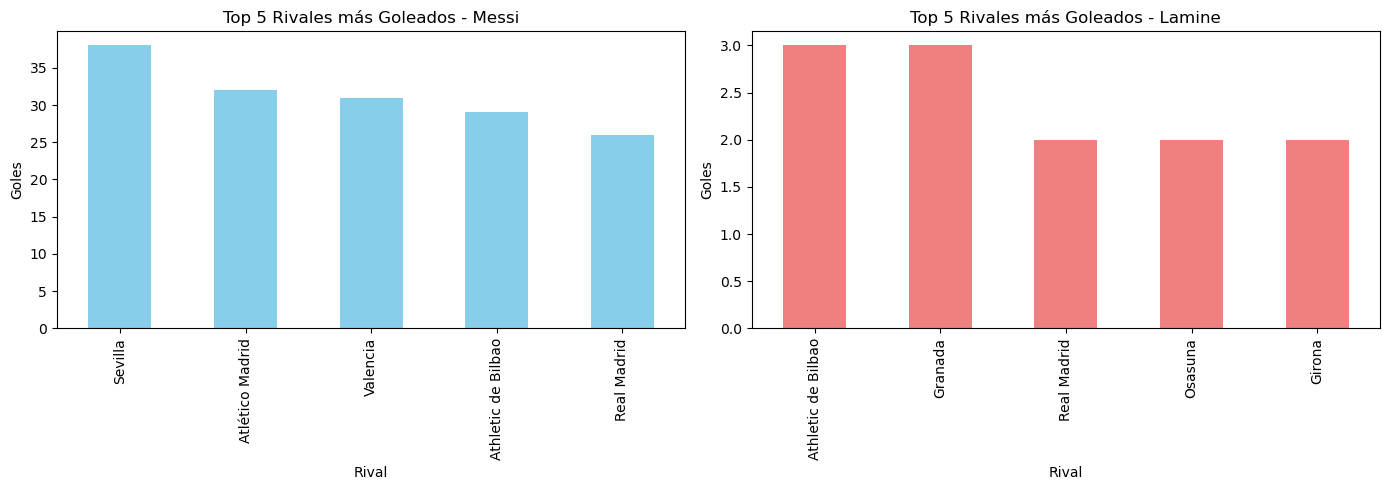

In [63]:
# Goles por equipo rival TOP 5

import matplotlib.pyplot as plt

# Agrupar y seleccionar top 5
top5_messi = df_messi.groupby("Rival_Team_Name")["Goals"].sum().sort_values(ascending=False).head(5)
top5_lamine = df_lamine.groupby("Rival_Team_Name")["Goals"].sum().sort_values(ascending=False).head(5)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

top5_messi.plot(kind="bar", ax=axes[0], color="skyblue", title="Top 5 Rivales más Goleados - Messi")
axes[0].set_ylabel("Goles")
axes[0].set_xlabel("Rival")

top5_lamine.plot(kind="bar", ax=axes[1], color="lightcoral", title="Top 5 Rivales más Goleados - Lamine")
axes[1].set_ylabel("Goles")
axes[1].set_xlabel("Rival")

plt.tight_layout()
plt.show()


C:\Users\juanm\AppData\Local\Temp\ipykernel_36460\667539159.py:15: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\juanm\miniconda3\envs\jcmdc_proy_abril\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


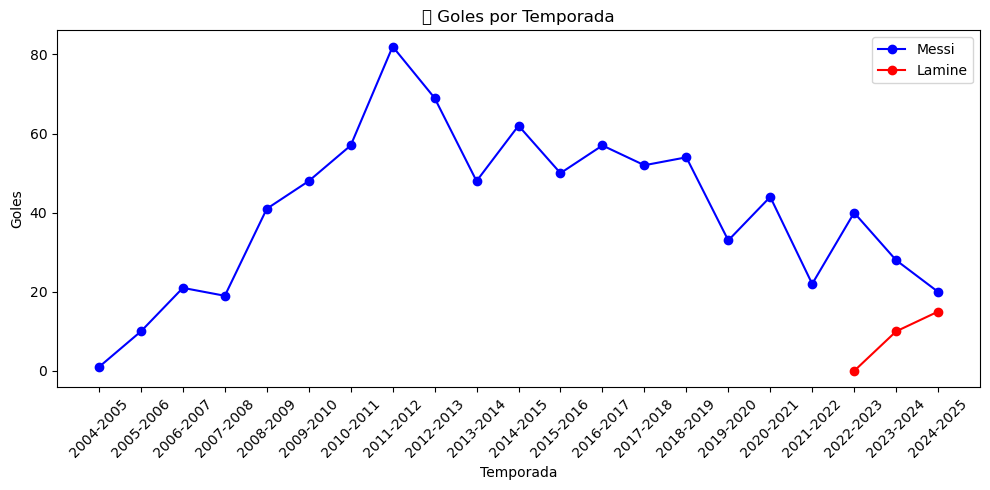

In [64]:
# Goles por temporada

# Agrupación por Season
goals_messi = df_messi.groupby("Season")["Goals"].sum()
goals_lamine = df_lamine.groupby("Season")["Goals"].sum()

plt.figure(figsize=(10, 5))
plt.plot(goals_messi.index, goals_messi.values, marker='o', label="Messi", color="blue")
plt.plot(goals_lamine.index, goals_lamine.values, marker='o', label="Lamine", color="red")
plt.title("📆 Goles por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Goles")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\juanm\AppData\Local\Temp\ipykernel_36460\1556083456.py:16: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\juanm\miniconda3\envs\jcmdc_proy_abril\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


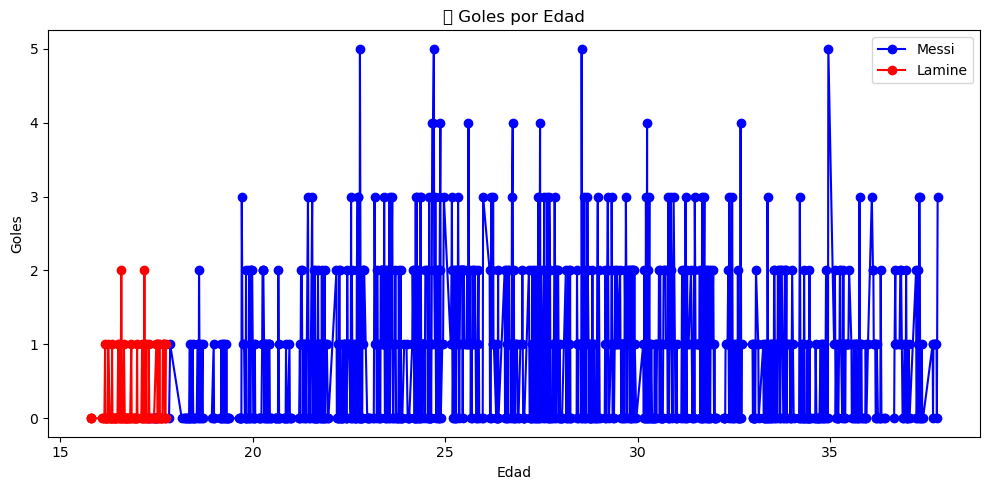

In [65]:
# Goles por edad

# Asegurar que Age es numérica


goles_edad_messi = df_messi.groupby("Age")["Goals"].sum()
goles_edad_lamine = df_lamine.groupby("Age")["Goals"].sum()

plt.figure(figsize=(10, 5))
plt.plot(goles_edad_messi.index, goles_edad_messi.values, label="Messi", color="blue", marker='o')
plt.plot(goles_edad_lamine.index, goles_edad_lamine.values, label="Lamine", color="red", marker='o')
plt.title("🎯 Goles por Edad")
plt.xlabel("Edad")
plt.ylabel("Goles")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\juanm\AppData\Local\Temp\ipykernel_36460\1743680865.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\juanm\miniconda3\envs\jcmdc_proy_abril\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


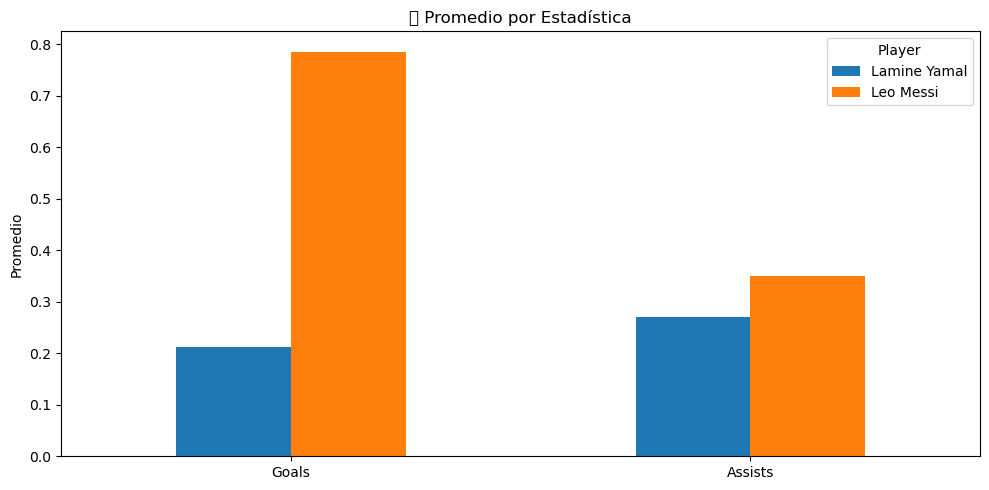

In [66]:
# Promedios por estadística

promedios = df_all.groupby("Player")[["Goals", "Assists"]].mean().T

promedios.plot(kind="bar", figsize=(10, 5), title="📊 Promedio por Estadística")
plt.ylabel("Promedio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



# Información sobre Messi

In [67]:
import pandas as pd

# Filtrar partidos donde el Barcelona fue local o visitante
rivales_local = df_cleaned[df_cleaned["Home Team"] == "FC Barcelona"]["Away Team"]
rivales_visitante = df_cleaned[df_cleaned["Away Team"] == "FC Barcelona"]["Home Team"]

# Unir ambas listas y eliminar duplicados
rivales = pd.concat([rivales_local, rivales_visitante]).drop_duplicates().reset_index(drop=True)

# Ajustar el límite de filas que pandas puede mostrar
pd.set_option('display.max_rows', None)  # Esto asegura que todas las filas se muestren

# Mostrar listado completo de rivales
print("Lista de rivales del FC Barcelona:")
print(rivales)



Lista de rivales del FC Barcelona:
0                     Albacete
1                       Getafe
2                      Levante
3                       Málaga
4                      Osasuna
5                      Chelsea
6                   Real Betis
7              Atlético Madrid
8                Real Zaragoza
9                       Alavés
10          Athletic de Bilbao
11               Celta de Vigo
12                     Sevilla
13            Racing Santander
14               Panathinaikos
15                     Udinese
16                    Espanyol
17               Real Mallorca
18         Deportivo La Coruña
19                 Real Madrid
20                   Liverpool
21                    Valencia
22           Manchester United
23                      Celtic
24                  Villarreal
25           Recreativo Huelva
26             Glasgow Rangers
27                  UD Almería
28          Olympique Lyonnais
29              Bayern München
30              Sporting Gijón
31  

In [68]:
# Filtrar partidos donde el Barcelona fue local
partidos_locales = df_cleaned[df_cleaned['Home Team'] == 'FC Barcelona']  # Ajusta 'FC Barcelona' si es necesario

# Sumar los goles de Messi en esos partidos
total_goles_locales = partidos_locales['Goals'].sum()

print(f"Total de goles de Messi en los partidos donde el Barcelona fue local: {total_goles_locales}")



Total de goles de Messi en los partidos donde el Barcelona fue local: 400


In [69]:
# Filtrar partidos donde el Barcelona fue visitante
partidos_visitantes = df_cleaned[df_cleaned['Away Team'] == 'FC Barcelona']  # Ajusta 'FC Barcelona' si es necesario

# Sumar los goles de Messi en esos partidos
total_goles_visitantes = partidos_visitantes['Goals'].sum()

print(f"Total de goles de Messi en los partidos donde el Barcelona fue visitante: {total_goles_visitantes}")

Total de goles de Messi en los partidos donde el Barcelona fue visitante: 272


Total de goles de Messi en la carrera: 858

📈 Goles por año:
 Year
2004     0
2005     3
2006    12
2007    31
2008    22
2009    41
2010    60
2011    59
2012    91
2013    45
2014    58
2015    52
2016    59
2017    54
2018    51
2019    50
2020    27
2021    43
2022    35
2023    28
2024    29
2025     8
Name: Goals, dtype: int64


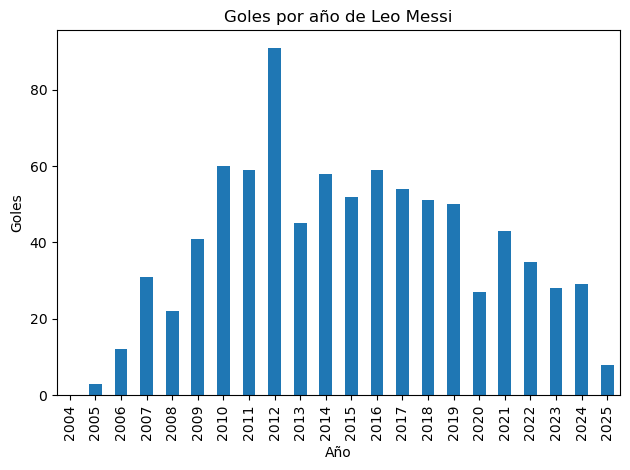

In [70]:
import matplotlib.pyplot as plt

# Total de goles
total_goles = df_cleaned['Goals'].sum()
print(f"Total de goles de Messi en la carrera: {total_goles}")

# Goles por año
df_cleaned["Year"] = df_cleaned["Date"].dt.year
goles_por_año = df_cleaned.groupby("Year")["Goals"].sum()
print("\n📈 Goles por año:\n", goles_por_año)

# Gráfico de Goles por año
goles_por_año.plot(kind="bar", title="Goles por año de Leo Messi")
plt.ylabel("Goles")
plt.xlabel("Año")
plt.tight_layout()
plt.show()


Total de goles de Messi en la carrera: 858

📅 Goles por temporada:
 Season
2004-2005     1
2005-2006    10
2006-2007    21
2007-2008    19
2008-2009    41
2009-2010    48
2010-2011    57
2011-2012    82
2012-2013    69
2013-2014    48
2014-2015    62
2015-2016    50
2016-2017    57
2017-2018    52
2018-2019    54
2019-2020    33
2020-2021    44
2021-2022    22
2022-2023    40
2023-2024    28
2024-2025    20
Name: Goals, dtype: int64


<Axes: title={'center': 'Total de Goles por Temporada'}, xlabel='Temporada', ylabel='Goles'>

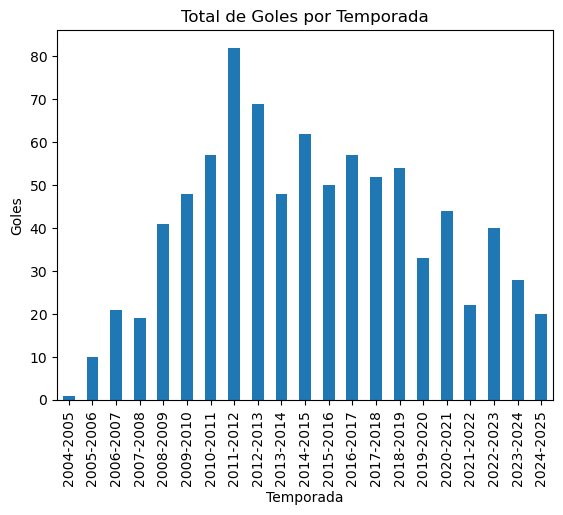

In [71]:
# Total de goles en la temporada
total_goles = df_cleaned['Goals'].sum()
print(f"Total de goles de Messi en la carrera: {total_goles}")

#Goles por temporada
goles_por_temporada = df_cleaned.groupby("Season")["Goals"].sum()
print("\n📅 Goles por temporada:\n", goles_por_temporada)

# Gráfico de Goles por temporada
goles_por_temporada = df_cleaned.groupby('Season')['Goals'].sum()
goles_por_temporada.plot(kind='bar', title='Total de Goles por Temporada', xlabel='Temporada', ylabel='Goles')



🏆 Top competiciones con más goles:
 Competition
La Liga                   474
UEFA Champions League     129
Copa del Rey               56
International friendly     51
Major League Soccer        24
Name: Goals, dtype: int64


<Axes: title={'center': 'Top competiciones con más goles de Leo Messi'}, xlabel='Competition'>

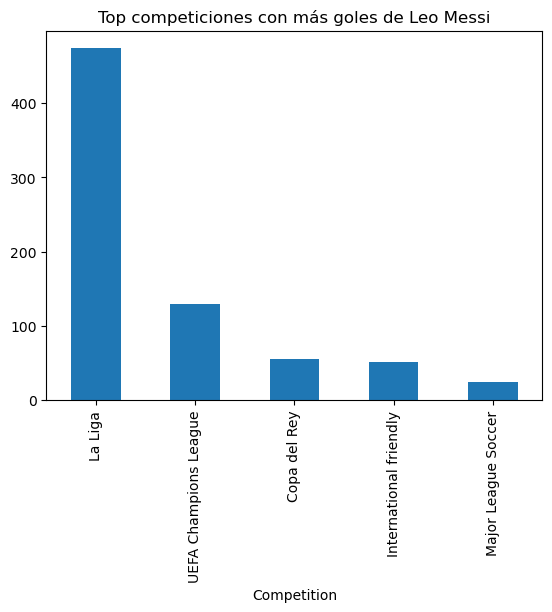

In [72]:
# Top competiciones con más goles
top_competiciones = df_cleaned.groupby("Competition")["Goals"].sum().sort_values(ascending=False).head(5)
print("\n🏆 Top competiciones con más goles:\n", top_competiciones)

# Gráfico de Top competiciones con más goles
top_competiciones.plot(kind="bar", title="Top competiciones con más goles de Leo Messi")

In [73]:
# Asegurarnos de que 'Minutos' es numérico y luego calcular el promedio de goles por minuto
df_cleaned['Minutes'] = pd.to_numeric(df_cleaned['Minutes'], errors='coerce')  # Convertir Minutos a numérico

# Total de minutos jugados
total_minutos = df_cleaned['Minutes'].sum()

# Promedio de goles por minuto (total de goles / total de minutos jugados)
promedio_goles_por_minuto = total_minutos / total_goles if total_goles > 0 else 0

# Mostrar los resultados
print(f"Promedio de goles de Messi por minuto: Metió un gol cada {promedio_goles_por_minuto:.2f} minutos.")

Promedio de goles de Messi por minuto: Metió un gol cada 104.36 minutos.


In [74]:
promedio_goles = df_cleaned['Goals'].mean()
print(f"Promedio de goles por partido: {promedio_goles}")


Promedio de goles por partido: 0.7857142857142857


Total de asistencias de Messi en la carrera: 382

🏆 Asistencias totales por temporada:
 Season
2011-2012    34
2014-2015    32
2010-2011    29
2015-2016    27
2022-2023    26
2019-2020    26
2017-2018    21
2018-2019    20
2008-2009    19
2012-2013    18
2016-2017    18
2020-2021    17
2023-2024    17
2021-2022    16
2013-2014    16
2007-2008    16
2009-2010    12
2024-2025     7
2005-2006     6
2006-2007     5
2004-2005     0
Name: Assists, dtype: int64


<Axes: title={'center': 'Total de Asistencias por Temporada'}, xlabel='Temporada', ylabel='Asistencias'>

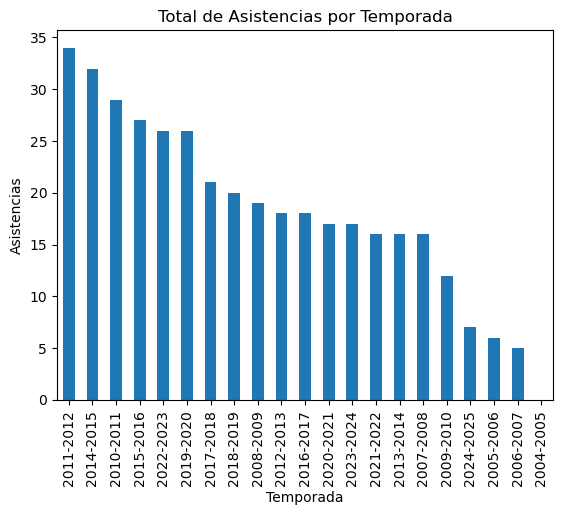

In [92]:
# Mostrar las asistencias totales
asistencias_totales = df_cleaned['Assists'].sum()
print(f"Total de asistencias de Messi en la carrera: {asistencias_totales}")

asistencias_por_temporada = df.groupby('Season')['Assists'].sum().sort_index()

# Mostrar las asistencias por competición ordenados de mayor a menor

asistencias_por_temporada = asistencias_por_temporada.sort_values(ascending=False)
print("\n🏆 Asistencias totales por temporada:\n", asistencias_por_temporada)
asistencias_por_temporada.plot(kind='bar', title='Total de Asistencias por Temporada', xlabel='Temporada', ylabel='Asistencias')


<Axes: title={'center': 'Goles por Mes'}, xlabel='Mes', ylabel='Goles'>

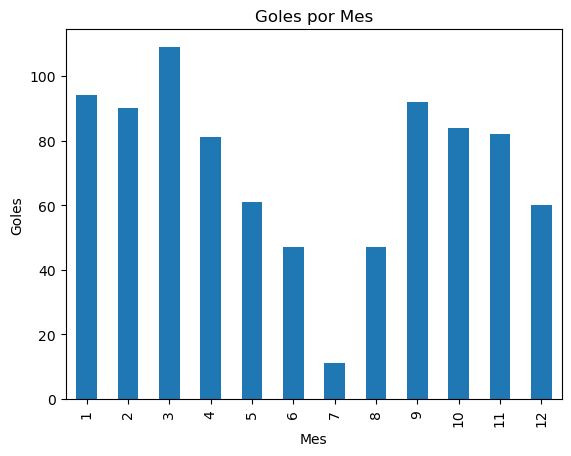

In [77]:
# Goles por mes

df_cleaned['Month'] = df_cleaned['Date'].dt.month
goles_por_mes = df_cleaned.groupby('Month')['Goals'].sum()
goles_por_mes.plot(kind='bar', title='Goles por Mes', xlabel='Mes', ylabel='Goles')


✅ Datos procesados guardados en: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril\data\processed\messi_cleaned_data.csv

📊 Goles y asistencias - Home vs Away:
            Goals  Assists
Home/Away                
Away         340      180
Home         518      202
🖼️ Guardado: local_vs_visitante.png


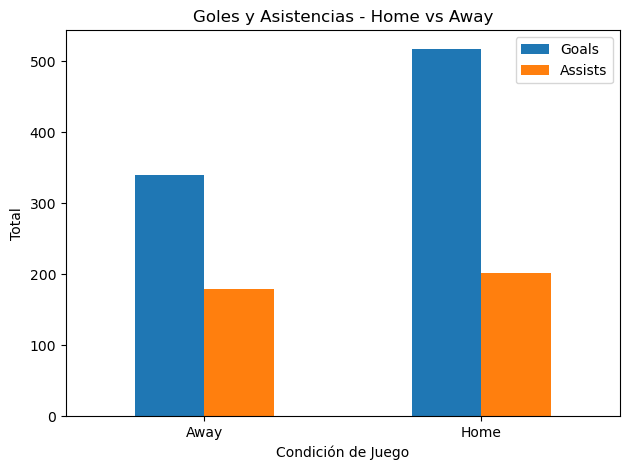

In [78]:
from src.processing import process_data
from src.analysis import plot_local_vs_visitante

# Obtener el DataFrame limpio
df = process_data(return_df=True)

# Mostrar y guardar el gráfico local vs visitante
plot_local_vs_visitante(df, save=True)



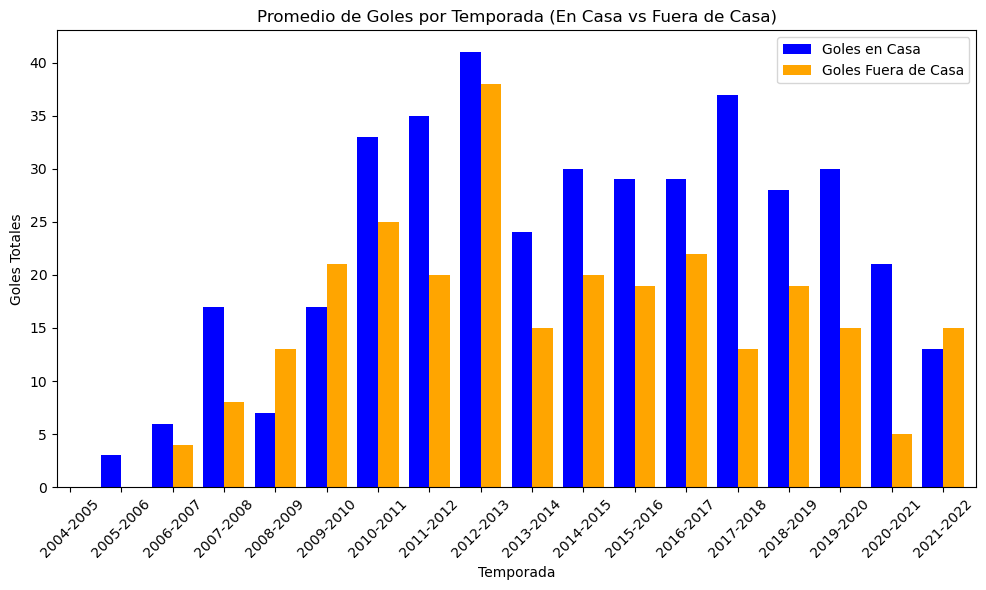

In [79]:
# Promedio de Goles por Temporada (Home vs Away)

# Filtrar goles por temporada
df_cleaned['Season'] = df_cleaned['Date'].dt.year.astype(str) + "-" + (df_cleaned['Date'].dt.year + 1).astype(str)

# Goles de Messi en casa (FC Barcelona como local)
goles_locales_season = df_cleaned[df_cleaned["Home Team"] == "FC Barcelona"].groupby("Season")["Goals"].sum()

# Goles de Messi fuera de casa (FC Barcelona como visitante)
goles_visitantes_season = df_cleaned[df_cleaned["Away Team"] == "FC Barcelona"].groupby("Season")["Goals"].sum()

# Graficar comparación de goles por temporada
plt.figure(figsize=(10, 6))
goles_locales_season.plot(kind='bar', label='Goles en Casa', width=0.4, position=1, color='blue')
goles_visitantes_season.plot(kind='bar', label='Goles Fuera de Casa', width=0.4, position=0, color='orange')
plt.title("Promedio de Goles por Temporada (En Casa vs Fuera de Casa)")
plt.xlabel("Temporada")
plt.ylabel("Goles Totales")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Lamine Yamal

<Axes: title={'center': 'Goles y asistencias por temporada'}, xlabel='Season'>

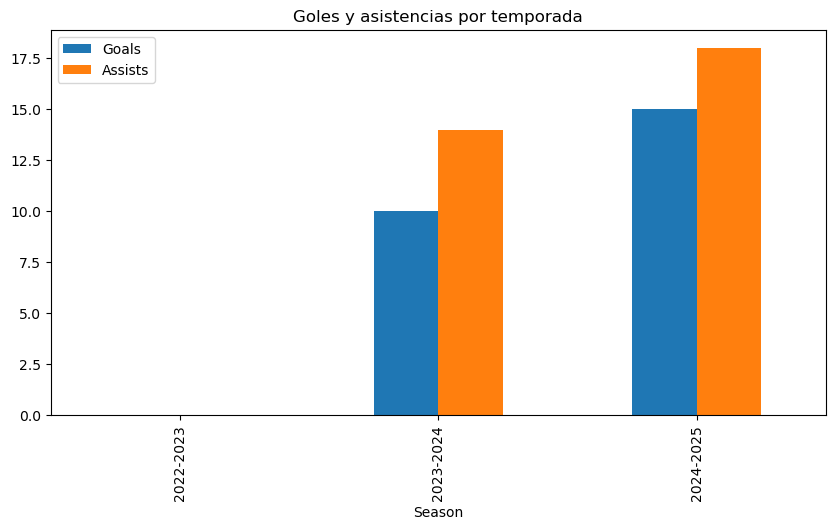

In [82]:
# 📊 Goles y asistencias por edad

df_cleaned_yamal.groupby("Season")[["Goals", "Assists"]].sum().plot(kind="bar", figsize=(10, 5), title="Goles y asistencias por temporada")


<Axes: title={'center': 'Minutos jugados por temporada'}, xlabel='Season', ylabel='Minutos'>

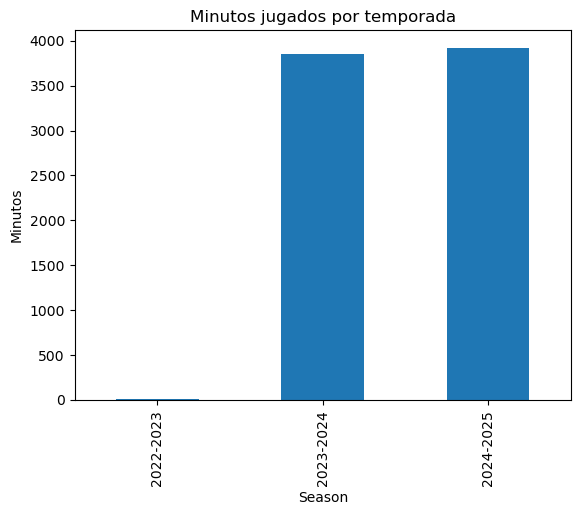

In [83]:
# 📈 Minutos jugados por temporada

df_cleaned_yamal.groupby("Season")["Minutes"].sum().plot(kind="bar", title="Minutos jugados por temporada", ylabel="Minutos")


<Axes: title={'center': 'Titular vs Suplente'}, ylabel='count'>

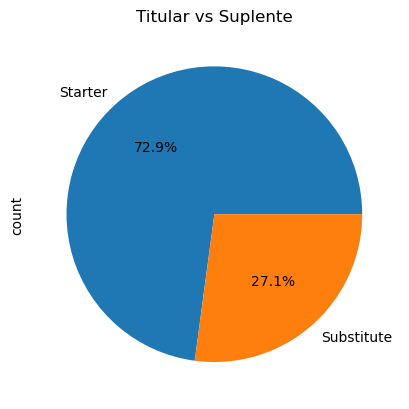

In [84]:
# ⚽ Distribución de titularidades vs suplencias

df_cleaned_yamal["Lineup"].value_counts().plot(kind="pie", autopct="%1.1f%%", title="Titular vs Suplente")


<Axes: title={'center': 'Local vs Visitante'}, xlabel='Home/Away'>

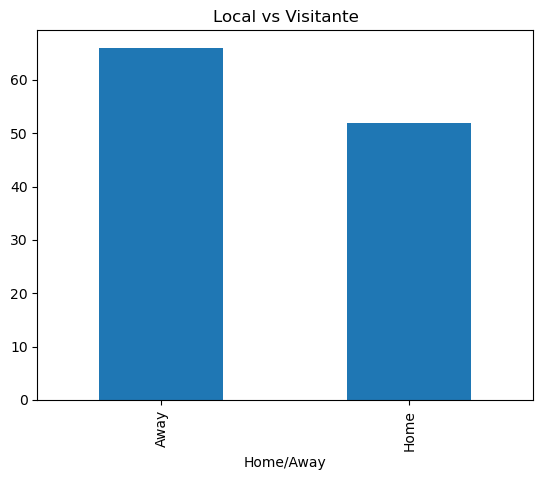

In [85]:
# 🏟️ Actuaciones como local vs visitante

df_cleaned_yamal["Home/Away"].value_counts().plot(kind="bar", title="Local vs Visitante")


<Axes: title={'center': 'Evolución de minutos por edad'}, xlabel='Age', ylabel='Minutes'>

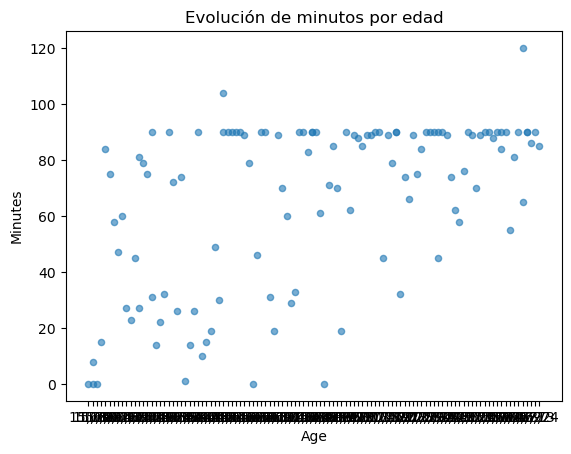

In [86]:
# 🧠 Evolución de minutos por partido (scatter por edad)

df_cleaned_yamal.plot.scatter(x="Age", y="Minutes", title="Evolución de minutos por edad", alpha=0.6)


# Comparativa Messi vs Lamine

In [87]:
print("📊 Comparativa rápida:")
print(f"Messi - Goles totales: {df_cleaned['Goals'].sum()}, Asistencias: {df_cleaned['Assists'].sum()}, Partidos: {len(df_cleaned)}")
print(f"Lamine - Goles totales: {df_cleaned_yamal['Goals'].sum()}, Asistencias: {df_cleaned_yamal['Assists'].sum()}, Partidos: {len(df_cleaned_yamal)}")



📊 Comparativa rápida:
Messi - Goles totales: 858, Asistencias: 382, Partidos: 1092
Lamine - Goles totales: 25, Asistencias: 32, Partidos: 118


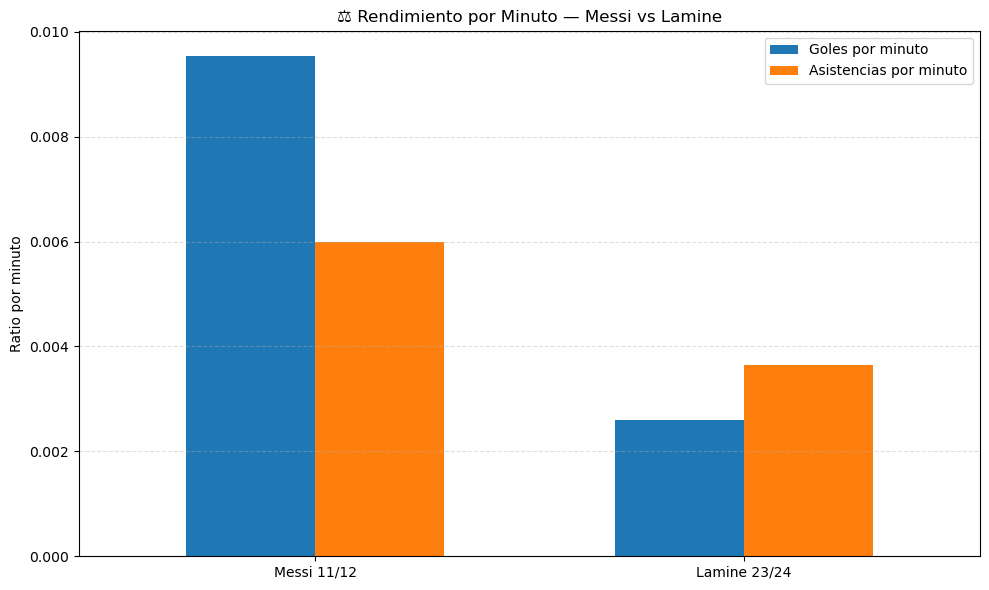

In [88]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar temporadas específicas
messi_1112 = df_cleaned[df_cleaned["Season"] == "2011-2012"]
lamine_2324 = df_cleaned_yamal[df_cleaned_yamal["Season"] == "2023-2024"]

# Extraer métricas
goles_messi = messi_1112["Goals"].sum()
goles_lamine = lamine_2324["Goals"].sum()
asis_messi = messi_1112["Assists"].sum()
asis_lamine = lamine_2324["Assists"].sum()
min_messi = messi_1112["Minutes"].sum()
min_lamine = lamine_2324["Minutes"].sum()

# Calcular métricas por minuto
stats_por_minuto = {
    "Goles por minuto": [goles_messi / min_messi, goles_lamine / min_lamine],
    "Asistencias por minuto": [asis_messi / min_messi, asis_lamine / min_lamine],
}

# Crear DataFrame comparativo
df_minuto = pd.DataFrame(stats_por_minuto, index=["Messi 11/12", "Lamine 23/24"])

# 📈 Gráfico
df_minuto.plot(kind="bar", figsize=(10, 6), title="⚖️ Rendimiento por Minuto — Messi vs Lamine", width=0.6)
plt.ylabel("Ratio por minuto")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.legend(loc="upper right")
plt.show()





# Test de hipótesis

In [89]:
import pandas as pd
from scipy.stats import ttest_ind

# --- UNIFICACIÓN Y PREPARACIÓN ---
df_messi["Player"] = "Leo Messi"
df_lamine["Player"] = "Lamine Yamal"
df = pd.concat([df_messi, df_lamine], ignore_index=True)

# --- FORMATO DE LA EDAD ---
df["Age"] = pd.to_numeric(df["Age"].astype(str).str.replace(",", "."), errors="coerce")

# --- FILTRAR SOLO PARTIDOS CON MINUTOS JUGADOS (> 0) Y EDAD <= 18 ---
df = df[df["Minutes"] > 0]
df_messi_u18 = df[(df["Player"] == "Leo Messi") & (df["Age"] <= 18)]
df_lamine_u18 = df[(df["Player"] == "Lamine Yamal") & (df["Age"] <= 18)]

# ✅ HIPÓTESIS 1: GC POR PARTIDO (Goles + Asistencias)
messi_gc = df_messi_u18["Goals"] + df_messi_u18["Assists"]
lamine_gc = df_lamine_u18["Goals"] + df_lamine_u18["Assists"]
# Prueba t de dos muestras independientes, que sirve para comparar si dos grupos tienen medias significativamente diferentes.
t1, p1 = ttest_ind(messi_gc.dropna(), lamine_gc.dropna(), equal_var=False)

# ✅ HIPÓTESIS 2: MINUTOS POR PARTIDO
t2, p2 = ttest_ind(df_messi_u18["Minutes"].dropna(), df_lamine_u18["Minutes"].dropna(), equal_var=False)

# ✅ HIPÓTESIS 3: ASISTENCIAS POR PARTIDO
t3, p3 = ttest_ind(df_messi_u18["Assists"].dropna(), df_lamine_u18["Assists"].dropna(), equal_var=False)

# --- RESULTADOS CLAROS Y EXPLICATIVOS ---
print("\n📊 CONTRASTE DE HIPÓTESIS — MESSI VS LAMINE (<18 AÑOS, Minutes > 0)")
print("=" * 60)

# Hipótesis 1: GC por partido
mean_gc_messi = messi_gc.mean()
mean_gc_lamine = lamine_gc.mean()
print("\n⚽ Hipótesis 1: Goal Contribution por partido")
print(f"   Messi GC/partido:  {mean_gc_messi:.2f}")
print(f"   Lamine GC/partido: {mean_gc_lamine:.2f}")
print(f"   p-value = {p1:.4f}")
if p1 < 0.05:
    print("   ✅ Diferencia significativa.")
    print("   🏆 Gana:", "Messi" if mean_gc_messi > mean_gc_lamine else "Lamine Yamal")
else:
    print("   ❌ No hay diferencia significativa entre ambos.")

# Hipótesis 2: Minutos jugados
mean_min_messi = df_messi_u18["Minutes"].mean()
mean_min_lamine = df_lamine_u18["Minutes"].mean()
print("\n⏱️ Hipótesis 2: Minutos promedio por partido")
print(f"   Messi:  {mean_min_messi:.2f} minutos")
print(f"   Lamine: {mean_min_lamine:.2f} minutos")
print(f"   p-value = {p2:.4f}")
if p2 < 0.05:
    print("   ✅ Diferencia significativa.")
    print("   🏆 Gana:", "Messi" if mean_min_messi > mean_min_lamine else "Lamine Yamal")
else:
    print("   ❌ No hay diferencia significativa.")

# Hipótesis 3: Asistencias por partido
mean_ast_messi = df_messi_u18["Assists"].mean()
mean_ast_lamine = df_lamine_u18["Assists"].mean()
print("\n🎯 Hipótesis 3: Asistencias promedio por partido")
print(f"   Messi:  {mean_ast_messi:.2f}")
print(f"   Lamine: {mean_ast_lamine:.2f}")
print(f"   p-value = {p3:.4f}")
if p3 < 0.05:
    print("   ✅ Diferencia significativa.")
    print("   🏆 Gana:", "Messi" if mean_ast_messi > mean_ast_lamine else "Lamine Yamal")
else:
    print("   ❌ No hay diferencia significativa.")

print("=" * 60)



📊 CONTRASTE DE HIPÓTESIS — MESSI VS LAMINE (<18 AÑOS, Minutes > 0)

⚽ Hipótesis 1: Goal Contribution por partido
   Messi GC/partido:  0.11
   Lamine GC/partido: 0.50
   p-value = 0.0078
   ✅ Diferencia significativa.
   🏆 Gana: Lamine Yamal

⏱️ Hipótesis 2: Minutos promedio por partido
   Messi:  26.33 minutos
   Lamine: 68.83 minutos
   p-value = 0.0044
   ✅ Diferencia significativa.
   🏆 Gana: Lamine Yamal

🎯 Hipótesis 3: Asistencias promedio por partido
   Messi:  0.00
   Lamine: 0.28
   p-value = 0.0000
   ✅ Diferencia significativa.
   🏆 Gana: Lamine Yamal


# Extra SQL Messi

In [90]:
# 📦 Cargar variables de entorno desde .env (asegúrate de tener el archivo en la raíz del proyecto)
from dotenv import load_dotenv
import os
load_dotenv()

# ✅ Recuperar credenciales de la base de datos
host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

# 🛠️ Agregar carpeta src/ al path para poder importar módulos personalizados
import sys
from pathlib import Path

root_path = Path().resolve()  # Ajusta esto si estás dentro de otra carpeta como notebooks/
src_path = root_path / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# 🧩 Importar función para obtener el engine de conexión a MySQL
from db import get_engine

# ⚙️ Crear el engine de conexión
engine = get_engine()


In [91]:
# 🧼 Importar función de procesamiento (desde src/processing.py)
from processing import process_data

# 🧠 Ejecutar la función para obtener el DataFrame procesado
df = process_data(return_df=True)

# 👀 Verificar columnas del DataFrame
print("Columnas del DataFrame:", df.columns.tolist())  # Confirmar que tenga "Home/Away" y demás

# 💾 Guardar el DataFrame en la base de datos
df.to_sql("messi_career_data", con=engine, if_exists="replace", index=False)

# 🔍 Comprobar que la tabla se creó correctamente
import pandas as pd
pd.read_sql("SHOW COLUMNS FROM messi_career_data;", engine)



✅ Datos procesados guardados en: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Evolve_Proyecto_Abril\data\processed\messi_cleaned_data.csv
Columnas del DataFrame: ['Date', 'Season', 'Age', 'Player', 'Player_Team', 'Home/Away', 'Competition', 'Home Team', 'Result', 'Away Team', 'Rival_Team_Name', 'Lineup', 'Minutes', 'Goals', 'Assists', 'Cards']


RuntimeError: 'cryptography' package is required for sha256_password or caching_sha2_password auth methods

In [ ]:
# Goles y asistencias por temporada

import pandas as pd
import plotly.express as px
from src.db import get_engine

engine = get_engine()

query = """
SELECT
  `Season`,
  SUM(`Goals`) AS Total_Goals,
  SUM(`Assists`) AS Total_Assists
FROM messi_career_data
GROUP BY `Season`
ORDER BY `Season`;
"""

df = pd.read_sql(query, engine)

fig = px.bar(df, x="Season", y=["Total_Goals", "Total_Assists"],
             title="⚽ Goles y 🎯 Asistencias por Temporada",
             barmode="group")
fig.show()


In [ ]:
# Goles como local vs visitante

import pandas as pd
import plotly.express as px
from src.db import get_engine

engine = get_engine()

query = """
SELECT
  `Home/Away` AS `Local/Visitante`,
  SUM(`Goals`) AS Total_Goals
FROM messi_career_data
GROUP BY `Home/Away`;
"""

df = pd.read_sql(query, engine)

fig = px.bar(df, x="Local/Visitante", y="Total_Goals",
             title="🏠 Goles Local vs Visitante",
             text_auto=True, labels={"Total_Goals": "Goles"})
fig.update_layout(yaxis_title="Goles")
fig.show()


In [ ]:
# Goles por competición

query = """
SELECT
  `Competition`,
  SUM(`Goals`) AS Total_Goals
FROM messi_career_data
GROUP BY `Competition`
ORDER BY Total_Goals DESC;
"""

df = pd.read_sql(query, engine)

fig = px.bar(df, x="Competition", y="Total_Goals",
             title="🏆 Goles por Competición",
             text_auto=True)
fig.update_layout(xaxis_tickangle=-45, yaxis_title="Goles")
fig.show()


In [ ]:
# Goles por mes (tendencia estacional)

query = """
SELECT
  MONTH(`Date`) AS Month,
  SUM(`Goals`) AS Total_Goals
FROM messi_career_data
GROUP BY MONTH(`Date`)
ORDER BY Month;
"""

df = pd.read_sql(query, engine)

fig = px.bar(df, x="Month", y="Total_Goals",
             title="📅 Goles por Mes",
             labels={"Month": "Mes", "Total_Goals": "Goles"},
             text_auto=True)
fig.update_layout(yaxis_title="Goles", xaxis_title="Mes")
fig.show()


In [ ]:
# Top 10 Total de Goles en Casa y Fuera de Casa por Rivales

import pandas as pd
import plotly.express as px
from src.db import get_engine

engine = get_engine()

query = """
SELECT
  CASE
    WHEN mc.`Player_Team` = mc.`Home Team` THEN mc.`Away Team`
    ELSE mc.`Home Team`
  END AS Rival_Team_Name,
  TRIM(mc.`Home/Away`) AS Home_Away,
  SUM(mc.Goals) AS Total_Goals
FROM messi_career_data mc
WHERE mc.`Player` = 'Leo Messi'
  AND mc.`Player_Team` IS NOT NULL
  AND (
    (mc.`Player_Team` = mc.`Home Team` AND mc.`Away Team` NOT IN ('Argentina', 'FC Barcelona', 'Paris Saint-Germain', 'Inter Miami CF'))
    OR
    (mc.`Player_Team` = mc.`Away Team` AND mc.`Home Team` NOT IN ('Argentina', 'FC Barcelona', 'Paris Saint-Germain', 'Inter Miami CF'))
  )
  AND mc.Goals > 0
  AND (
    mc.`Home Team` IS NOT NULL AND mc.`Away Team` IS NOT NULL
  )
GROUP BY
  CASE
    WHEN mc.`Player_Team` = mc.`Home Team` THEN mc.`Away Team`
    ELSE mc.`Home Team`
  END,
  TRIM(mc.`Home/Away`)
HAVING Rival_Team_Name IS NOT NULL;
"""

# Cargar resultados
df = pd.read_sql(query, engine)

# 🏆 Obtener Top 10 rivales con más goles (sumando Home + Away)
top10_rivales = (
    df.groupby("Rival_Team_Name")["Total_Goals"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# 🧽 Filtrar solo esos 10
df_top10 = df[df["Rival_Team_Name"].isin(top10_rivales)]

# Orden para gráfico
orden_rivales = (
    df_top10.groupby("Rival_Team_Name")["Total_Goals"]
    .sum()
    .sort_values(ascending=False)
    .index.tolist()
)

# 🎨 Gráfico
fig = px.bar(
    df_top10,
    x="Rival_Team_Name",
    y="Total_Goals",
    color="Home_Away",
    category_orders={"Rival_Team_Name": orden_rivales},
    title="🔟 Rivales más goleados por Messi (Local vs Visitante)",
    text_auto=True,
    barmode="group"
)

fig.update_layout(
    xaxis_title="Rival",
    yaxis_title="Total de Goles",
    xaxis_tickangle=-45
)

fig.show()

